In [1]:
### This block is mainly for Google Colab

# try:
#     from Bio import SeqIO, AlignIO
# except:
#     !pip install biopython
#     from Bio import SeqIO, AlignIO

# try:
#     import torch
# except:
#     !pip install torch
#     import torch

# try:
#   import pytorch_lightning as pl
# except:
#   !pip install pytorch-lightning
#   import pytorch_lightning as pl

In [1]:
import os
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt

import torch
from Bio import SeqIO, AlignIO

import warnings
# warnings.filterwarnings('ignore')

# np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(threshold=100)
torch.set_printoptions(edgeitems=10)

In [2]:
if not os.path.exists('./data/PF00144_full_labeled.fasta'):
    !wget --no-check-certificate -O ./data/PF00144_full_labeled.fasta https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_labeled.fasta
if not os.path.exists('./data/PF00042.alignment.full.gz'):
    !wget --no-check-certificate -O ./data/PF00042.alignment.full.gz https://www.ebi.ac.uk/interpro/wwwapi//entry/pfam/PF00042/?annotation=alignment:full\&download

In [3]:
aa1_to_index = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
                'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
                'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
                'Y': 19, 'X':20, 'Z': 21, '-': 22, 'B': 23}
# aa1 = "ACDEFGHIKLMNPQRSTVWYXZ-B"
MAX_INDEX = 20  # NUM_CLASSES = MAX_INDEX + 1
GAP_INDEX = MAX_INDEX
GAP_THRESHOLD = 0.99
SIMILARITY_THRESHOLD = 0.9
SIMILARITY_THRESHOLDS =[0.2, 0.4, 0.6, 0.8]

BATCH_SIZE = 64 

In [5]:
def numeric_encode(seq, max_index=None):
    seq_numeric = np.array([aa1_to_index[aa] for aa in str(seq).upper().replace('.', '-')])
    if max_index is not None:
        seq_numeric[seq_numeric > max_index] = max_index
    return torch.from_numpy(seq_numeric)


def filter_gaps(index_seqs, gap_index, threshold=0.9):
    N = index_seqs.shape[0]
    gap_pos = torch.sum(index_seqs == gap_index, dim=0) > threshold * N
    filtered_sequences = index_seqs[:, ~gap_pos]
    return filtered_sequences

def calculate_similarity_matrix(index_seqs, num_classes):
    N = len(index_seqs)
    L = len(index_seqs[0])
    C = num_classes
    # index_seqs = torch.tensor(index_seqs)
    one_hot_seqs = torch.nn.functional.one_hot(index_seqs, num_classes=C)
    one_hot_seqs[index_seqs > 19] = 0
    seq_lengths = (index_seqs <= 19).sum(dim=1).unsqueeze(-1)
    flat_one_hot_seqs = one_hot_seqs.view(N, L*C)
    similarity_matrix = torch.mm(flat_one_hot_seqs.float(),
                                 flat_one_hot_seqs.float().t()) / seq_lengths
    return similarity_matrix


def calculate_weights(similarity_matrix, similarity_thresholds):
    weights = {}
    for st in similarity_thresholds:
        w = 1.0 / similarity_matrix.gt(st).sum(dim=1).float()
        weights[str(st)] = w
    return weights


def filter_sequences(similarity_matrix, threshold=0.9):
    N = similarity_matrix.shape[0]
    keep_idx = []
    rm_idx = set()
    for i in range(0, N):
        if i not in rm_idx:
            keep_idx.append(i)
            sim_idx = torch.nonzero(similarity_matrix[i][i+1:] > threshold).flatten() + (i+1)
            rm_idx.update(set(sim_idx.tolist()))
    return keep_idx


test_index_seqs = torch.randint(0, 5, size=(15, 10))
test_similarity_matrix = calculate_similarity_matrix(test_index_seqs, 20)
filter_sequences(test_similarity_matrix, 0.5)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Pre-processing 

In [4]:
### File Loading
is_loading = True

if is_loading is False:
    input_file = './data/PF00144_full_labeled.fasta'
    # input_file = './data/PF00042.alignment.full.gz'
    
    if input_file.endswith('.gz'):
        with gzip.open(input_file, 'rt') as handle:
            alignment = AlignIO.read(handle, "stockholm")
    elif input_file.endswith('.fasta'):
        with open(input_file, 'r') as f:
            alignment = AlignIO.read(f, "fasta")
    
    encoded_sequences = {}
    for record in alignment:
        # encoded_sequences[record.id] = one_hot_encode(record.seq)
        encoded_sequences[record.id] = numeric_encode(record.seq, MAX_INDEX)

In [5]:
### Pre-processing (filtering)
if is_loading is False:
    index_seqs = torch.stack(list(encoded_sequences.values()))
    print(f'Length of MSA: {len(index_seqs[0])}')
    index_seqs = filter_gaps(index_seqs, GAP_INDEX, GAP_THRESHOLD)
    print(f'Length of MSA after gap filtering: {len(index_seqs[0])}')
    print(f'Number of seqs: {len(index_seqs)}')
    similarity_matrix = calculate_similarity_matrix(index_seqs, MAX_INDEX+1)
    keep_indicies = filter_sequences(similarity_matrix, SIMILARITY_THRESHOLD)
    index_seqs = index_seqs[keep_indicies]
    print(f'Number of seqs after similarity filtering: {len(index_seqs)}') # 8364
    weights_dict = calculate_weights(similarity_matrix, SIMILARITY_THRESHOLDS)

In [6]:
torch_file = './data/index_seqs.pt'
if is_loading:
    index_seqs = torch.load(torch_file)
# torch.save(index_seqs, torch_file)

# Model 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

activation_dict = {
    'ReLU': nn.ReLU,
    'LeakyReLU': nn.LeakyReLU,
    'SELU': nn.SELU,
    'ELU': nn.ELU
}

class VAE(pl.LightningModule):    
    def __init__(self, input_dim, device='cpu', h_params=None):
        super().__init__()
        self._device = device
        self.h_params = {
            'z_dim': 2,
            'lr': 1e-3,
            'dropout': 0.1,
            'beta': 0.01,
            'activation': 'LeakyReLU',
            'dim1': 1500,
            'dim2': 1000,
            'is_annealing': True}
        if h_params is not None:
            self.h_params.update(h_params)
            if self.h_params['dim1'] < self.h_params['dim2']:
                self.h_params['dim1'], self.h_params['dim2'] = self.h_params['dim2'], self.h_params['dim1']
        self.save_hyperparameters(self.h_params)
        self.max_epochs = 20
        
        encoder_dims = [self.h_params['dim1'], self.h_params['dim2']]
        decoder_dims = [self.h_params['dim2'], self.h_params['dim1']]
        z_dim = self.h_params['z_dim']
        activation = activation_dict[self.h_params['activation']]

        # Build Encoder
        modules = []
        in_dim = input_dim
        for h_dim in encoder_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_dim, h_dim),
                    nn.Dropout(self.h_params['dropout']),
                    nn.BatchNorm1d(h_dim),
                    activation())
            )
            in_dim = h_dim

        self.encoder = nn.Sequential(*modules)
        self.encoder_mu = nn.Linear(encoder_dims[-1], z_dim)
        self.encoder_log_var = nn.Linear(encoder_dims[-1], z_dim)

        # Build Decoder
        modules = []
        in_dim = z_dim
        for h_dim in decoder_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_dim, h_dim),
                    nn.Dropout(self.h_params['dropout']),
                    nn.BatchNorm1d(h_dim),
                    activation())
            )
            in_dim = h_dim
        modules.append(
            nn.Sequential(
                nn.Linear(decoder_dims[-1], input_dim))
        )
        self.decoder = nn.Sequential(*modules)

        self.loss_fn = nn.CrossEntropyLoss(reduction='mean')
        self.eval_loss = []

    def encode(self, x): # x: [N, L]
        x_one_hot = nn.functional.one_hot(x.long(), MAX_INDEX+1).float() # [N, L, C]
        x_one_hot_flat = x_one_hot.reshape(x_one_hot.shape[0], -1) # [N, L*C]
        h = self.encoder(x_one_hot_flat)
        mu = self.encoder_mu(h)
        log_var = self.encoder_log_var(h)
        return mu, log_var

    def decode(self, z):
        h = self.decoder(z) # [N, L*C]
        N, LC = h.shape
        C = MAX_INDEX + 1
        L = LC // C
        h_reshaped = h.view(N, L, C)  # [N, L, C]
        h_softmax = torch.nn.functional.softmax(h_reshaped, dim=2)
        h_final = h_softmax.view(N, L*C) # [N, L*C]
        return h_final

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, n_samples=1):
        mu, log_var = self.encode(x)
        z_samples = self.reparameterize(mu, log_var)
        x_recon = self.decode(z_samples)
        return x_recon, mu, log_var

    def _step(self, batch, batch_idx, is_training=False):
        x = batch.long().to(self._device) # [N, L]
        x_recon, mu, log_var = self(x) # x_recon: [N, L*C]
        N, L = x.shape
        C = x_recon.shape[1] // L
        x_recon = x_recon.view(N, L, C)
        x = x.view(-1) # [N*L]
        x_recon = x_recon.view(-1, C) # [N*L, C]
        x_recon_logigts = torch.log(x_recon+1e-6)
        recon_loss = self.loss_fn(x_recon_logigts, x)
        kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0)
        if is_training and self.hparams['is_annealing']:
            beta = self.h_params['beta'] * self.current_epoch/self.max_epochs
        else:
            beta = self.h_params['beta']
        loss = recon_loss + beta * kl_loss
        return loss, recon_loss, kl_loss

    def training_step(self, batch, batch_idx):
        loss, recon_loss, kl_loss = self._step(batch, batch_idx, is_training=True)
        self.log_dict(
            {'train_loss': loss,
             'recon_loss': recon_loss,
             'kl_loss': kl_loss},
            on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, recon_loss, kl_loss = self._step(batch, batch_idx)
        self.log_dict(
            {'val_loss': loss},
            on_step=False, on_epoch=True)
        self.eval_loss.append(loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss, recon_loss, kl_loss = self._step(batch, batch_idx)
        self.log_dict(
            {'test_loss': loss},
            on_step=False, on_epoch=True)
        
        return loss

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.eval_loss).mean()
        self.log("ptl/val_loss", avg_loss, sync_dist=True)
        self.eval_loss.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.h_params['lr'])


# x = torch.randn(4, 141*21)
x = torch.randint(low=0, high=21, size=(32, 141)).to('cuda')
device = torch.device("cuda")  # or "cpu"
model_test = VAE(input_dim=141*21, device=device).to(device)
# model_test = model_test.to('cuda')

x_recon, mu, log_var = model_test(x)
print(f'x: {x.shape}')
print(f'x_recon: {x_recon.shape}')
print(f'mu: {mu.shape}')
print(f'log_var: {log_var.shape}')

# model_test = VAE(input_dim=141*21, device='cpu')
# x = torch.randint(low=0, high=21, size=(32, 141))
# mu, log_var = model_test.encode(x)
# z_samples = model_test.reparameterize(mu, log_var)
# x_recon = model_test.decode(z_samples)

x: torch.Size([32, 141])
x_recon: torch.Size([32, 2961])
mu: torch.Size([32, 2])
log_var: torch.Size([32, 2])


In [8]:
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

class ProteinDataModule(pl.LightningDataModule):
    def __init__(self, full_dataset, batch_size=128, weights=None, seed_value=42):
        super().__init__()
        self.full_dataset = full_dataset
        self.batch_size = batch_size
        self.weights = weights
        self.num_workers = 4  ### Let Ray Tune handle this?
        self.seed = torch.Generator().manual_seed(seed_value)

    def setup(self, stage=None):
        total_size = len(self.full_dataset)
        train_size = int(0.7 * total_size)
        val_size = int(0.15 * total_size)
        test_size = total_size - train_size - val_size

        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            self.full_dataset, [train_size, val_size, test_size], generator=self.seed)

        # Prepare weights for weighted random sampling in training loader
        if self.weights is not None:
            train_weights = self.weights[self.train_dataset.indices]
            self.train_sampler = WeightedRandomSampler(train_weights, num_samples=len(train_weights), replacement=True)
        else:
            self.train_sampler = None


    def train_dataloader(self):
        if self.train_sampler is not None:
            return DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=self.train_sampler, shuffle=False, num_workers=self.num_workers)
        else:
            return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [9]:
from pytorch_lightning.callbacks import TQDMProgressBar
from tqdm import tqdm

class CustomProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        """
        This method customizes the tqdm progress bar for validation.
        """
        # Create a simple progress bar with minimal information
        bar = tqdm(
            desc='Validation',
            total=None,  # Total will be unknown; the bar will show as a simple spinner
            leave=True,  # Leave the progress bar displayed after validation is complete
            position=0,
            disable=self.is_disabled,  # Disable if progress bars are globally disabled
            dynamic_ncols=True,  # Adjust to the terminal window width
            smoothing=0  # Disable smoothing for more responsive updates
        )
        return bar

# Training

In [10]:
# Create a TensorBoardLogger
from pytorch_lightning.loggers import TensorBoardLogger

In [11]:
N, L = index_seqs.shape
C = MAX_INDEX + 1

h_params = {
    'batch_size': 64,
    'z_dim': 2,
    'lr': 1e-3,
    'dropout': 0.3,
    'beta': 0.1,
    'activation': 'LeakyReLU',
    'dim1': 2000,
    'dim2': 1000,
    'is_annealing': False}

logger = TensorBoardLogger(save_dir='./lightning_logs', name=f'test')

device = torch.device("cuda")
vae_model = VAE(input_dim=L*C, device=device, h_params=h_params).to(device)
pdm = ProteinDataModule(index_seqs, batch_size=h_params['batch_size'], weights=None, seed_value=42)
trainer = pl.Trainer(max_epochs=20, callbacks=[CustomProgressBar()], logger=logger)
trainer.fit(model=vae_model, datamodule=pdm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/test
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder         | Sequential       | 28.6 M
1 | encoder_mu      | Linear           | 2.0 K 
2 | encoder_log_var | Linear           | 2.0 K 
3 | decoder         | Sequential       | 28.6 M
4 | loss_fn         | CrossEntropyLoss | 0     
-----------------------------------------------------
57.1 M    Trainable params
0         Non-trainable params
57.1 M    Total params
228.501   Total estimated model params size (MB)


Sanity Checking: |                                             | 0/? [00:00<?, ?it/s]

Training: |                                                    | 0/? [00:00<?, ?it/s]

Validation DataLoader 0: 100%|██████████████████████| 65/65 [00:00<00:00, 191.72it/s]
`Trainer.fit` stopped: `max_epochs=20` reached.


In [12]:
trainer.test(model=vae_model, datamodule=pdm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Testing: |                                                     | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.4863489866256714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.4863489866256714}]

# Hyperparameter Optimization

## Grid Search

In [16]:
# from itertools import product

# n_epochs = 2
# z_dim = 2
# lr = 1e-3
# dropouts = [0.1, 0.2, 0.5]
# betas = [1e-3, 1e-2, 0.1, 0.3]
# activations = ['LeakyReLU', 'ReLU', 'SELU', 'ELU']

# dropouts = [0.7, 0.2]
# betas = [1e-3, 1e-2]
# activations = [nn.LeakyReLU, nn.ReLU]

# N, L = index_seqs.shape
# C = MAX_INDEX + 1

# for dropout, beta, activation in product(dropouts, betas, activations):
#     h_params = {'lr': lr, 'dropout': dropout, 'batch_size': -1}
#     print(h_params)
#     pdm = ProteinDataModule(index_seqs, batch_size=BATCH_SIZE, weights=None, seed_value=42)
#     vae_model = VAE(input_dim=L*C, device='cuda', h_params=h_params)
#     vae_model = vae_model.to('cuda')
#     trainer = pl.Trainer(max_epochs=n_epochs, callbacks=[CustomProgressBar()])
#     trainer.fit(model=vae_model, datamodule=pdm)
#     break 

### Loading a trained model

In [ ]:
### Save the model
# from google.colab import drive
# drive.mount('/content/drive')

# model_path = "/content/drive/MyDrive/CSHL/Projects/vae_model_w08_0122.ckpt"
# trainer.save_checkpoint(model_path)

In [ ]:
### Load the model
N, L = index_seqs.shape
C = MAX_INDEX + 1

ct = 71

model_path = f'./lightning_logs/version_{ct}/checkpoints/epoch=19-step=5980.ckpt'
h_params = hp_dir[ct]
vae_model = VAE.load_from_checkpoint(checkpoint_path=model_path, input_dim=L*C, h_params=h_params)

## Ray Tune

In [31]:
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search import ConcurrencyLimiter
# from ray.tune.search.bayesopt import BayesOptSearch

from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer
from ray.train.lightning import RayDDPStrategy, RayLightningEnvironment, RayTrainReportCallback, prepare_trainer

from ray.air.integrations.wandb import WandbLoggerCallback

In [63]:
full_dataset = index_seqs
N, L = full_dataset.shape
C = MAX_INDEX + 1

seed = 42
weights = None

num_epochs = 3
num_workers = 1
num_gpus = 1
num_cpus = 5
num_samples = 5

# batch_unit = 64

def train_vae(config):
    dm = ProteinDataModule(full_dataset, batch_size=config['batch_size'], weights=None, seed_value=seed)
    device=torch.device('cuda')
    model = VAE(input_dim=L*C, device=device, h_params=config).to(device)
    
    trainer = pl.Trainer(
        devices="auto",
        accelerator="gpu",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
        enable_checkpointing=False
    )  # callbacks=[TuneReportCallback(metrics, on="validation_end")], ###
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

scaling_config = ScalingConfig(
    num_workers=num_workers, use_gpu=True, resources_per_worker={"CPU": num_cpus, "GPU": num_gpus}
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=1,
        checkpoint_score_attribute="ptl/val_loss",
        checkpoint_score_order="min",
    ),
    callbacks=[WandbLoggerCallback(project="Wandb_VAE_test")]
)

ray_trainer = TorchTrainer(
    train_vae,
    scaling_config=scaling_config,
    run_config=run_config,
)

search_space = { 
    'batch_size': tune.choice([32, 64, 128, 256]),
    'activation': tune.choice(['LeakyReLU']),
    'z_dim': tune.choice([2]),
    'beta': tune.choice([0.01]),
    'lr': tune.choice([1e-3]),
    'dropout': tune.uniform(0.1, 0.8),
    'dim1': tune.randint(100, 2000),
    'dim2': tune.randint(100, 2000)}

    #  'lr': tune.loguniform(1e-4, 1e-1),
    # 'encoder_dim1': tune.randint(200, 2000),
    # 'encoder_dim2': tune.randint(100, 1500),
    # 'decoder_dim1': tune.randint(100, 1500),
    # 'decoder_dim2': tune.randint(200, 2000),

def tune_vae_asha(num_samples=5):
    scheduler = ASHAScheduler(max_t=num_epochs, grace_period=3, reduction_factor=2)

    tuner = tune.Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=tune.TuneConfig(
            metric="ptl/val_loss",
            mode="min",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
        run_config=run_config,
    )
    return tuner.fit()

In [64]:
results = tune_vae_asha(num_samples)

2024-02-05 10:17:48,847	INFO wandb.py:307 -- Already logged into W&B.
2024-02-05 10:18:11,467	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 0.667 s, which may be a performance bottleneck.
2024-02-05 10:18:11,470	WARNING util.py:202 -- The `process_trial_result` operation took 0.670 s, which may be a performance bottleneck.
2024-02-05 10:18:11,471	WARNING util.py:202 -- Processing trial results took 0.671 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-02-05 10:18:11,473	WARNING util.py:202 -- The `process_trial_result` operation took 0.673 s, which may be a performance bottleneck.
2024-02-05 10:18:55,373	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 0.693 s, which may be a performance bottleneck.
2024-02-05 10:18:55,376	WARNING util.py:202 -- The `process_trial_result` operation took 0.696 s, which may be a performance bottleneck.
2024-02-05 10:18:55,377	WARNING util.py:202 -- 

In [61]:
results.get_best_result(metric="ptl/val_loss", mode="min")

Result(
  metrics={'val_loss': 1.2581979036331177, 'ptl/val_loss': 1.2584670782089233, 'train_loss': 1.2674760818481445, 'recon_loss': 1.227595567703247, 'kl_loss': 3.988147735595703, 'epoch': 4, 'step': 2990},
  path='/home/moon/ray_results/TorchTrainer_2024-02-05_09-36-57/TorchTrainer_03f02_00003_3_activation=LeakyReLU,batch_size=32,beta=0.0100,dim1=424,dim2=974,dropout=0.2710,lr=0.0058,z_dim=2_2024-02-05_09-36-57',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/home/moon/ray_results/TorchTrainer_2024-02-05_09-36-57/TorchTrainer_03f02_00003_3_activation=LeakyReLU,batch_size=32,beta=0.0100,dim1=424,dim2=974,dropout=0.2710,lr=0.0058,z_dim=2_2024-02-05_09-36-57/checkpoint_000004)
)

In [41]:
import yaml

model_path = os.path.join(results.get_best_result(metric="ptl/val_loss", mode="min").path, 'checkpoint_000014', 'checkpoint.ckpt')
# print(model_path)
hparams_path = os.path.join(results.get_best_result(metric="ptl/val_loss", mode="min").path, 'lightning_logs/version_0/hparams.yaml')

N, L = full_dataset.shape
C = MAX_INDEX + 1

with open(hparams_path, 'r') as stream:
	h_params = yaml.safe_load(stream)
device=torch.device('cuda')
vae_model = VAE.load_from_checkpoint(checkpoint_path=model_path, input_dim=L*C, h_params=h_params, device=device).to(device)

In [43]:
h_params

{'activation': 'LeakyReLU',
 'batch_size': 64,
 'beta': 0.01,
 'dim1': 1249,
 'dim2': 414,
 'dropout': 0.14073600684931487,
 'lr': 0.0018155020081841201,
 'z_dim': 2}

# Visualization

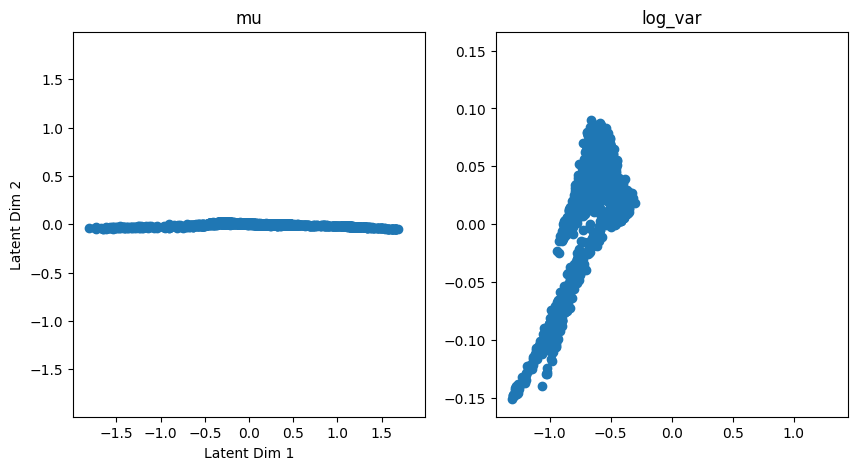

In [57]:
import matplotlib.pyplot as plt

vae_model.to('cuda')
vae_model.eval()
latents = []
vars = []
# labels = []
with torch.no_grad():
    for batch in pdm.val_dataloader():
        mu, log_var = vae_model.encode(batch.long().to('cuda'))
        latents.append(mu)
        vars.append(log_var)

latents = torch.cat(latents).cpu().numpy()
vars = torch.cat(vars).cpu().numpy()
# labels = torch.cat(labels).cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=[10, 5])
x_maxabs0 = np.max(np.abs(latents[:, 0]))*1.1
y_maxabs0 = np.max(np.abs(latents[:, 1]))*1.1

x_maxabs0 = np.max(np.abs(latents))*1.1
y_maxabs0 = x_maxabs0

x_maxabs1 = np.max(np.abs(vars[:, 0]))*1.1
y_maxabs1 = np.max(np.abs(vars[:, 1]))*1.1


axs[0].scatter(latents[:, 0], latents[:, 1])
axs[0].set_xlim(-x_maxabs0, x_maxabs0)
axs[0].set_ylim(-y_maxabs0, y_maxabs0 )
axs[0].set_xlabel('Latent Dim 1')
axs[0].set_ylabel('Latent Dim 2')
axs[0].set_title('mu')

axs[-1].scatter(vars[:, 0], vars[:, 1])
axs[-1].set_xlim(-x_maxabs1, x_maxabs1)
axs[-1].set_ylim(-y_maxabs1, y_maxabs1)
axs[-1].set_title('log_var')
# plt.xlabel('Latent Dim 1')
# plt.ylabel('Latent Dim 2')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

n_rows = 12
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=[5 * n_cols, 5 * n_rows+3])
for i in range(0, 48):
    h_params = hp_dir[i+67]
    model_path = f'./lightning_logs/version_{i+67}/checkpoints/epoch=19-step=5980.ckpt'
    vae_model = VAE.load_from_checkpoint(checkpoint_path=model_path, input_dim=L*C, h_params=h_params)
    vae_model.eval()
    latents = []
    with torch.no_grad():
        for batch in valid_loader:
            mu, log_var = vae_model.encode(batch.long())
            latents.append(mu)
    latents = torch.cat(latents).cpu().numpy()
    x_maxabs0 = np.max(np.abs(latents[:, 0]))*1.1
    y_maxabs0 = np.max(np.abs(latents[:, 1]))*1.1
    ax = axs[i//4][i%4]
    ax.scatter(latents[:, 0], latents[:, 1])
    ax.set_xlim(-x_maxabs0, x_maxabs0)
    ax.set_ylim(-y_maxabs0, y_maxabs0 )
    dropout = h_params['dropout']
    beta = h_params['beta']
    activation = h_params['activation']
    ax.set_title(f'(drop={dropout}, b={beta})\n{activation}')
    if i == n_rows * n_cols - 1:
        break

plt.suptitle('mu in the latent space (z_dim = 2)', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) 
plt.savefig('latents.pdf')
plt.show()